In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install ccxt
!pip install optuna

In [20]:
from model_utils import CryptoDataset, check_for_missing_data, normalize_data, create_targets, create_features, feature_cut, profitable_percent, distribution, pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np

In [2]:
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list your GPU


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
defeatNaNs = pipeline()

timeframe_filenames = {
    "1m": "data/DOGEUSD_1m_vo.csv",
    "3m": "data/DOGEUSD_3m_vo.csv",
    "5m": "data/DOGEUSD_5m_vo.csv",
    "15m": "data/DOGEUSD_15m_vo.csv",
    "30m": "data/DOGEUSD_30m_vo.csv" }

params = '5m', 20, 'StandardScaler', 194, 10, 0.1951912452248569, 0.9363313100924653, 0.8391044744981573, 0.0007191553099477651
defeatNaNs.load_file(filename=timeframe_filenames[params[0]])
defeatNaNs.pass_hyperparams(*params)
defeatNaNs.preprocess()
defeatNaNs.target_creation()

Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Frame: 0


In [3]:

# Objective function for optimization
def objective(trial):
    # Sample hyperparameters

    timeframe_filenames = {
    "1m": "data/DOGEUSD_1m_vo.csv",
    "3m": "data/DOGEUSD_3m_vo.csv",
    "5m": "data/DOGEUSD_5m_vo.csv",
    "15m": "data/DOGEUSD_15m_vo.csv",
    "30m": "data/DOGEUSD_30m_vo.csv"
}

    timeframe = trial.suggest_categorical('timeframe', ['1m', '3m', '5m', '15m', '30m'])
    timeframe_file = timeframe_filenames[timeframe]
    sample_size = trial.suggest_int('sample_size', 10000, 50000)
    num_indicators = trial.suggest_int('num_indicators', 5, 46)
    scaler_type = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    window_size = trial.suggest_int('window_size', 10, 200)  # Example range for window size
    look_ahead_size = trial.suggest_int('look_ahead_size', 5, 50)
    dropout_rate = trial.suggest_float('dropout', 0.05, 0.4, log=True)

    # Create the simulate trading values
    prediction_tolerance_max = trial.suggest_float('predTolMax', 0.8, 1)
    prediction_tolerance_min = trial.suggest_float('predTolMin', 0.8, 1)
    trade_threshold = trial.suggest_float('trade_threshold', 0.0005, .02)


    # print everthing
    print(f'HyperParams: Timeframe: {timeframe_file}, Num Indicators: {num_indicators}, Scaler: {scaler_type}, Window Size: {window_size}, Look ahead Size: {look_ahead_size}, Dropout: {dropout_rate}, Pred_tol_Max: {prediction_tolerance_max}, Pred_tol_Min: {prediction_tolerance_min}, Trade Threshold: {trade_threshold}')
    
    # Set the sample size
    #trial_data = trial_data.head(sample_size)
    
    current_model = pipeline()
    current_model.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)
    return current_model.full_stack(timeframe_file)
    
    # Return validation loss for optimization
    #val_loss = history.history['val_loss'][-1]
    #return val_loss


In [4]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)  # Run just one trial

[I 2024-12-23 09:43:36,831] A new study created in memory with name: no-name-bfec9e8f-c8d5-45fa-a882-55e1c3050370


HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 44, Scaler: RobustScaler, Window Size: 17, Look ahead Size: 7, Dropout: 0.17778608802784043, Pred_tol_Max: 0.8056553816629662, Pred_tol_Min: 0.9473870163207412, Trade Threshold: 0.0013464395659299154
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!


[W 2024-12-23 09:43:40,429] Trial 0 failed with parameters: {'timeframe': '5m', 'sample_size': 40454, 'num_indicators': 44, 'scaler': 'RobustScaler', 'window_size': 17, 'look_ahead_size': 7, 'dropout': 0.17778608802784043, 'predTolMax': 0.8056553816629662, 'predTolMin': 0.9473870163207412, 'trade_threshold': 0.0013464395659299154} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_4536/1772160090.py", line 36, in objective
    return current_model.full_stack(timeframe_file)
  File "/home/jonas/Projects/trading_bot/model_utils.py", line 556, in full_stack
    self.target_creation()
  File "/home/jonas/Projects/trading_bot/model_utils.py", line 498, in target_creation
    self.X, self.y  = create_targets(self.data, self.window_size, self.look_ahead_size)
  File "/home/j

KeyboardInterrupt: 

In [4]:

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Run 100 trials

# Get the best parameters
print("Best parameters:", study.best_params)


[I 2024-12-23 09:43:44,609] A new study created in memory with name: no-name-d85279c3-b80b-492c-987f-b989b6d1302f


HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 42, Scaler: StandardScaler, Window Size: 120, Look ahead Size: 40, Dropout: 0.4666422704054496, Pred_tol_Max: 0.8942142271484483, Pred_tol_Min: 0.9029285954752144, Trade Threshold: 0.001044285319202293
Dataset loaded from data/DOGEUSD_3m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


I0000 00:00:1734972264.452077    4536 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-12-23 09:44:26.572114: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 753762240 exceeds 10% of free system memory.
2024-12-23 09:44:27.702904: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 753762240 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1734972273.220961    5000 service.cc:148] XLA service 0x708ce804a9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734972273.221126    5000 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-23 09:44:33.419845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734972274.246105    5000 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1169 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 57252899717120.0000 - mae: 1887551.2500 

I0000 00:00:1734972278.865484    5000 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1169/1169 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - loss: 5702011584512.0000 - mae: 137525.1406 - val_loss: 39275.1797 - val_mae: 21.5089
Epoch 2/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 113627.8906 - mae: 18.3023 - val_loss: 957.5208 - val_mae: 8.4280
Epoch 3/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 94513.1250 - mae: 48.6303 - val_loss: 7132.9170 - val_mae: 5.4911
Epoch 4/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 115496.0312 - mae: 21.6686 - val_loss: 448.1245 - val_mae: 1.9712
Epoch 5/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 147689.2500 - mae: 32.0226 - val_loss: 296445.3750 - val_mae: 156.2812
Epoch 6/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 129678552.0000 - mae: 1690.0448 - val_loss: 46658.7305 - val_mae: 60.6360
Epoch 7/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 30248842.0000 - mae: 437.1423 - val_loss: 965013120.0000 - val_mae: 7949.8472
Epoch 8/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss

[I 2024-12-23 09:49:09,102] Trial 0 finished with value: 0.2756090392697977 and parameters: {'timeframe': '3m', 'sample_size': 38241, 'num_indicators': 42, 'scaler': 'StandardScaler', 'window_size': 120, 'look_ahead_size': 40, 'dropout': 0.4666422704054496, 'predTolMax': 0.8942142271484483, 'predTolMin': 0.9029285954752144, 'trade_threshold': 0.001044285319202293}. Best is trial 0 with value: 0.2756090392697977.


Predictions:[[ 0.12380179 -0.03066096]
 [ 0.4603251   0.13306332]
 [ 0.03270921 -0.09673531]
 [ 0.14084612 -0.04314777]
 [ 0.13420847 -0.01867963]
 [ 0.16529022 -0.06710952]
 [ 0.13015035 -0.06641255]
 [ 0.13354905 -0.04330534]
 [-0.10328258 -0.02550352]
 [ 0.18787958 -0.07504445]]
Y-Tests:[[ 0.00417246 -0.00417246]
 [ 0.00247831 -0.00743494]
 [ 0.00647668 -0.01295337]
 [ 0.00689655 -0.00275862]
 [ 0.00110988 -0.01886792]
 [-0.00138313 -0.02074689]
 [ 0.01907357 -0.00817439]
 [ 0.00814901 -0.00232829]
 [ 0.01396973 -0.        ]
 [ 0.00873362 -0.        ]]
TP:[np.float32(0.11070532), np.float32(0.41162923), np.float32(0.029249039), np.float32(0.1259466), np.float32(0.12001112), np.float32(0.14780487), np.float32(0.11638229), np.float32(0.11942146), 0, np.float32(0.16800459)]
SL:[np.float32(-0.027684655), np.float32(0.12014667), np.float32(-0.08734507), np.float32(-0.038959358), np.float32(-0.016866375), np.float32(-0.060595103), np.float32(-0.059965786), np.float32(-0.039101634), 0, np.

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 2.0635 - mae: 0.5861 - val_loss: 0.1710 - val_mae: 0.1944
Epoch 2/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2802 - mae: 0.2072 - val_loss: 0.0417 - val_mae: 0.1220
Epoch 3/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0616 - mae: 0.1325 - val_loss: 0.0253 - val_mae: 0.0849
Epoch 4/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0399 - mae: 0.0949 - val_loss: 0.0088 - val_mae: 0.0602
Epoch 5/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0185 - mae: 0.0690 - val_loss: 0.0077 - val_mae: 0.0449
Epoch 6/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0166 - mae: 0.0526 - val_loss: 0.0093 - val_mae: 0.0363
Epoch 7/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0090 - mae: 0.0406 - val_loss: 0.0059 - val_mae: 0.0313
Epoch 8/50
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0074 - mae: 0.0342 - val_loss: 0.0059 - val_mae: 0.0

[I 2024-12-23 09:59:36,762] Trial 1 finished with value: 0.0 and parameters: {'timeframe': '3m', 'sample_size': 10329, 'num_indicators': 33, 'scaler': 'StandardScaler', 'window_size': 14, 'look_ahead_size': 6, 'dropout': 0.23730048527291417, 'predTolMax': 0.8433276061148962, 'predTolMin': 0.9696989641750287, 'trade_threshold': 0.01860798824305518}. Best is trial 1 with value: 0.0.


Predictions:[[ 0.00230351 -0.00221248]
 [ 0.0022199  -0.0021981 ]
 [ 0.00131127 -0.00135765]
 [ 0.0012264  -0.00121162]
 [ 0.00164922 -0.00154348]
 [ 0.00232389 -0.0074373 ]
 [ 0.00227767 -0.00219925]
 [ 0.00142989 -0.00141629]
 [ 0.00177649 -0.0016409 ]
 [ 0.00281241 -0.0035986 ]]
Y-Tests:[[ 0.00121212 -0.00484848]
 [ 0.00290276 -0.00290276]
 [ 0.         -0.00236686]
 [ 0.         -0.00120482]
 [ 0.00236407  0.00236407]
 [-0.00108696 -0.01086957]
 [ 0.         -0.00113122]
 [ 0.         -0.00472813]
 [ 0.00140845 -0.0028169 ]
 [ 0.004158   -0.002079  ]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_5m_vo.csv, Num Indicators: 14, Scaler: StandardScaler, Window Size: 63, Look ahead Size: 49, Dropout: 0.11855839106997812, Pred_tol_Max: 0.9256496031734313, Pred_tol_Min: 0.9924896035354203, Trade Threshold: 0.01009682506739656
Dataset loaded from data/DOGEUSD_5m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 3691.9907 - mae: 12.5622 - val_loss: 53.6209 - val_mae: 0.8084
Epoch 2/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 12.0512 - mae: 0.5987 - val_loss: 1.8179 - val_mae: 0.3474
Epoch 3/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 1.5724 - mae: 0.3290 - val_loss: 0.5154 - val_mae: 0.2418
Epoch 4/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.5368 - mae: 0.2287 - val_loss: 0.1336 - val_mae: 0.1704
Epoch 5/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.3235 - mae: 0.1817 - val_loss: 0.0572 - val_mae: 0.1350
Epoch 6/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0905 - mae: 0.1353 - val_loss: 0.0635 - val_mae: 0.1129
Epoch 7/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.1041 - mae: 0.1169 - val_loss: 0.0360 - val_mae: 0.0948
Epoch 8/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0473 - mae: 0.0967 - val_loss: 0.1950 - val

[I 2024-12-23 10:07:54,176] Trial 2 finished with value: 0.3218959279348758 and parameters: {'timeframe': '5m', 'sample_size': 36578, 'num_indicators': 14, 'scaler': 'StandardScaler', 'window_size': 63, 'look_ahead_size': 49, 'dropout': 0.11855839106997812, 'predTolMax': 0.9256496031734313, 'predTolMin': 0.9924896035354203, 'trade_threshold': 0.01009682506739656}. Best is trial 1 with value: 0.0.


Predictions:[[ 0.01340501 -0.0101343 ]
 [ 0.01144112 -0.01094238]
 [ 0.00886175 -0.00737244]
 [ 0.00850091 -0.00808303]
 [ 0.01103754 -0.01028053]
 [ 0.00971719 -0.00919347]
 [ 0.01242682 -0.00994289]
 [ 0.00737297 -0.00805905]
 [ 0.00281083 -0.00979892]
 [ 0.00512989 -0.0058586 ]]
Y-Tests:[[ 0.01152369 -0.00128041]
 [ 0.00470588 -0.03529412]
 [ 0.00373599 -0.00373599]
 [ 0.00111768 -0.00191601]
 [ 0.00477327 -0.00477327]
 [ 0.00241838 -0.0120919 ]
 [ 0.00814901 -0.        ]
 [ 0.0013459  -0.00538358]
 [ 0.00318979 -0.00271132]
 [ 0.00030166 -0.01749623]]
TP:[np.float32(0.0124083385), np.float32(0.010590471), 0, 0, np.float32(0.010216893), 0, np.float32(0.01150288), 0, 0, 0]
SL:[np.float32(-0.010058182), np.float32(-0.010860195), 0, 0, np.float32(-0.010203316), 0, np.float32(-0.009868219), 0, 0, 0]
Tot Profit: -0.3218959279348758
HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 38, Scaler: MinMaxScaler, Window Size: 68, Look ahead Size: 36, Dropout: 0.2688572431114632, P

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 0.1543 - mae: 0.2530 - val_loss: 0.0148 - val_mae: 0.0965
Epoch 2/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0108 - mae: 0.0746 - val_loss: 0.0117 - val_mae: 0.0857
Epoch 3/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0076 - mae: 0.0579 - val_loss: 0.0089 - val_mae: 0.0736
Epoch 4/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0063 - mae: 0.0507 - val_loss: 0.0068 - val_mae: 0.0618
Epoch 5/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0055 - mae: 0.0463 - val_loss: 0.0060 - val_mae: 0.0545
Epoch 6/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0055 - mae: 0.0445 - val_loss: 0.0052 - val_mae: 0.0460
Epoch 7/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0054 - mae: 0.0429 - val_loss: 0.0048 - val_mae: 0.0424
Epoch 8/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0054 - mae: 0.0422 - val_loss: 0.0048 - val_mae: 

[I 2024-12-23 10:27:02,557] Trial 3 finished with value: 0.6407304383974043 and parameters: {'timeframe': '3m', 'sample_size': 22873, 'num_indicators': 38, 'scaler': 'MinMaxScaler', 'window_size': 68, 'look_ahead_size': 36, 'dropout': 0.2688572431114632, 'predTolMax': 0.8785173289084551, 'predTolMin': 0.888539168440571, 'trade_threshold': 0.004045720985954123}. Best is trial 1 with value: 0.0.


Predictions:[[ 0.0081938  -0.0036154 ]
 [ 0.01379272 -0.00345926]
 [ 0.0069014  -0.0044096 ]
 [ 0.00466987 -0.00415502]
 [ 0.00667295 -0.00315816]
 [ 0.00543323 -0.00375137]
 [ 0.00439349 -0.00377705]
 [ 0.00254866 -0.01450678]
 [ 0.00616864 -0.00347036]
 [ 0.00488274 -0.00571594]]
Y-Tests:[[ 0.00218341 -0.00655022]
 [ 0.01766784 -0.00117786]
 [ 0.00987306 -0.00282087]
 [ 0.00139082 -0.00417246]
 [ 0.00590319 -0.00472255]
 [ 0.00235018 -0.00587544]
 [ 0.         -0.00799087]
 [ 0.00307692 -0.02051282]
 [ 0.00742574 -0.        ]
 [ 0.00277393 -0.00277393]]
TP:[np.float32(0.0071983924), np.float32(0.012117144), np.float32(0.006062996), np.float32(0.0041025593), np.float32(0.005862298), np.float32(0.0047731907), np.float32(0.0038597558), 0, np.float32(0.0054192594), np.float32(0.004289574)]
SL:[np.float32(-0.0032124214), np.float32(-0.0030736895), np.float32(-0.003918102), np.float32(-0.0036918942), np.float32(-0.0028061504), np.float32(-0.0033332398), np.float32(-0.0033560605), 0, np.flo

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


2024-12-23 10:27:34.228687: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 467915232 exceeds 10% of free system memory.
2024-12-23 10:27:34.867041: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 467915232 exceeds 10% of free system memory.


Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - loss: 7280167747584.0000 - mae: 146160.0469 - val_loss: 2600939552768.0000 - val_mae: 129750.6094
Epoch 2/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 461135069315072.0000 - mae: 210560.3281 - val_loss: 35345952768.0000 - val_mae: 12293.2959
Epoch 3/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 1022117760211091456.0000 - mae: 2240472.7500 - val_loss: 123640460500533248.0000 - val_mae: 9763398.0000
Epoch 4/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 6464009532342272.0000 - mae: 7040670.0000 - val_loss: 51109053857792.0000 - val_mae: 917004.2500
Epoch 5/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 159421988601856.0000 - mae: 1114401.7500 - val_loss: 17487888384.0000 - val_mae: 32175.4414
Epoch 6/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 295335723008.0000 - mae: 115217.6875 - val_loss: 9080169472.0000 - val_mae: 5627.5654
Epoch 7/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/st

[I 2024-12-23 10:39:24,301] Trial 4 finished with value: -1.90001306229935 and parameters: {'timeframe': '30m', 'sample_size': 38441, 'num_indicators': 24, 'scaler': 'RobustScaler', 'window_size': 131, 'look_ahead_size': 48, 'dropout': 0.35900350785803137, 'predTolMax': 0.9360453901861273, 'predTolMin': 0.8453393970786874, 'trade_threshold': 0.009488108381206584}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 4.441829   -0.16132268]
 [ 4.5232134  -0.1747525 ]
 [ 4.6005497  -0.18522003]
 [ 4.405857   -0.18488884]
 [ 4.5456276  -0.20780379]
 [ 4.5161495  -0.2278374 ]
 [ 4.7539067  -0.19484448]
 [ 2.9175289  -0.12620932]
 [56.051678   -7.4747443 ]
 [15.179399   -0.78904986]]
Y-Tests:[[ 0.1875     -0.        ]
 [ 0.06646972  0.0014771 ]
 [ 0.04405874 -0.00400534]
 [ 0.01380012 -0.1676351 ]
 [ 0.06599553  0.00838926]
 [ 0.         -0.02777778]
 [ 0.0373444   0.0013278 ]
 [ 0.03800475 -0.00593824]
 [ 0.00722892 -0.07871486]
 [ 0.08561983 -0.02446281]]
TP:[np.float32(4.157754), np.float32(4.233933), np.float32(4.3063235), np.float32(4.124082), np.float32(4.254914), np.float32(4.227321), np.float32(4.4498725), np.float32(2.7309394), np.float32(52.466915), np.float32(14.208607)]
SL:[np.float32(-0.13637242), np.float32(-0.14772518), np.float32(-0.15657379), np.float32(-0.15629382), np.float32(-0.17566474), np.float32(-0.19259994), np.float32(-0.16470972), np.float32(-0.106689714), np.f

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.1042 - mae: 0.1691 - val_loss: 28339.9062 - val_mae: 3.4971
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 12582.9414 - mae: 1.0253 - val_loss: 0.0077 - val_mae: 0.0649
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0079 - mae: 0.0629 - val_loss: 0.0064 - val_mae: 0.0583
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0064 - mae: 0.0544 - val_loss: 0.0056 - val_mae: 0.0505
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0064 - mae: 0.0483 - val_loss: 0.0056 - val_mae: 0.0496
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0052 - mae: 0.0460 - val_loss: 0.0051 - val_mae: 0.0464
Epoch 7/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 37784.7188 - mae: 1.3668 - val_loss: 0.0049 - val_mae: 0.0424
Epoch 8/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 0.0045 - mae: 0.0404 - val_loss: 0.0048

[I 2024-12-23 11:04:22,315] Trial 5 finished with value: 0.6301782974627735 and parameters: {'timeframe': '30m', 'sample_size': 38374, 'num_indicators': 8, 'scaler': 'MinMaxScaler', 'window_size': 126, 'look_ahead_size': 31, 'dropout': 0.17533676903572348, 'predTolMax': 0.8288076800697297, 'predTolMin': 0.9970363731994731, 'trade_threshold': 0.017307010670758318}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.02237007 -0.02322833]
 [ 0.01495835 -0.02174623]
 [ 0.01589297 -0.02126366]
 [ 0.00956617 -0.02604098]
 [ 0.03458286 -0.03144893]
 [ 0.01327133 -0.02175163]
 [ 0.06942146 -0.02285896]
 [ 0.01534049 -0.02803628]
 [ 0.00272625 -0.0278514 ]
 [ 0.01309851 -0.02339888]]
Y-Tests:[[ 0.03125    -0.        ]
 [ 0.0442055   0.0083632 ]
 [ 0.01240402 -0.00945068]
 [ 0.01129146 -0.00635145]
 [ 0.02180685 -0.05434406]
 [ 0.00574713 -0.00718391]
 [ 0.         -0.03571429]
 [ 0.03169014 -0.00234742]
 [ 0.02946593 -0.00736648]
 [ 0.02409639 -0.0060241 ]]
TP:[np.float32(0.018540489), 0, 0, 0, np.float32(0.028662536), 0, np.float32(0.057537038), 0, 0, 0]
SL:[np.float32(-0.023159487), 0, 0, 0, np.float32(-0.031355724), 0, np.float32(-0.02279122), 0, 0, 0]
Tot Profit: -0.6301782974627735
HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 13, Scaler: MinMaxScaler, Window Size: 125, Look ahead Size: 15, Dropout: 0.21339319306707782, Pred_tol_Max: 0.8729110557733277, Pred_tol_M

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - loss: 0.5738 - mae: 0.2566 - val_loss: 0.0108 - val_mae: 0.0788
Epoch 2/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0152 - mae: 0.0913 - val_loss: 0.0096 - val_mae: 0.0796
Epoch 3/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0096 - mae: 0.0694 - val_loss: 0.0091 - val_mae: 0.0781
Epoch 4/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 0.0074 - mae: 0.0585 - val_loss: 0.0083 - val_mae: 0.0739
Epoch 5/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 0.0067 - mae: 0.0540 - val_loss: 0.0073 - val_mae: 0.0675
Epoch 6/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0060 - mae: 0.0502 - val_loss: 0.0065 - val_mae: 0.0606
Epoch 7/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 0.0056 - mae: 0.0481 - val_loss: 0.0062 - val_mae: 0.0586
Epoch 8/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 0.0055 - mae: 0.0460 - val_loss: 0.0058 - val_mae: 

[I 2024-12-23 11:27:28,836] Trial 6 finished with value: 0.07608521883057755 and parameters: {'timeframe': '15m', 'sample_size': 26186, 'num_indicators': 13, 'scaler': 'MinMaxScaler', 'window_size': 125, 'look_ahead_size': 15, 'dropout': 0.21339319306707782, 'predTolMax': 0.8729110557733277, 'predTolMin': 0.8447867551305803, 'trade_threshold': 0.01718939058188734}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.01238206 -0.01146226]
 [ 0.01293776 -0.0107502 ]
 [ 0.01077818 -0.00894636]
 [ 0.0168441  -0.00950598]
 [ 0.01080366 -0.01080662]
 [ 0.01139516 -0.01126681]
 [ 0.00932942 -0.00795465]
 [ 0.0066771  -0.00457353]
 [ 0.01944333 -0.0204912 ]
 [ 0.0132415  -0.01232103]]
Y-Tests:[[ 0.00133156 -0.04394141]
 [-0.00221729 -0.02549889]
 [ 0.0245098  -0.        ]
 [ 0.01246537 -0.0166205 ]
 [ 0.00352609 -0.01763047]
 [ 0.00334821 -0.01116071]
 [ 0.01141227 -0.00142653]
 [ 0.00205114 -0.0038288 ]
 [ 0.00250941 -0.05520703]
 [-0.00594354 -0.02377415]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, np.float32(0.016972298), 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, np.float32(-0.017310698), 0]
Tot Profit: -0.07608521883057755
HyperParams: Timeframe: data/DOGEUSD_3m_vo.csv, Num Indicators: 24, Scaler: RobustScaler, Window Size: 134, Look ahead Size: 43, Dropout: 0.348326354959775, Pred_tol_Max: 0.8401541729062335, Pred_tol_Min: 0.8941428884378938, Trade Threshold: 0.016373572535267777
Dataset loaded from data/DOGE

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


2024-12-23 11:28:02.204971: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480817728 exceeds 10% of free system memory.


Epoch 1/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - loss: 294287535243264.0000 - mae: 648741.0625 - val_loss: 53411938304.0000 - val_mae: 10018.8750
Epoch 2/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 143519905742848.0000 - mae: 111489.9375 - val_loss: 17506218541056.0000 - val_mae: 124893.7812
Epoch 3/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 101828976967680.0000 - mae: 395148.9375 - val_loss: 511873843200.0000 - val_mae: 51605.3086
Epoch 4/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 1404591276032.0000 - mae: 29495.9434 - val_loss: 2064193280.0000 - val_mae: 3202.8213
Epoch 5/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 472758714368.0000 - mae: 13659.9482 - val_loss: 2670422272.0000 - val_mae: 4037.8176
Epoch 6/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 2980584882176.0000 - mae: 15288.1064 - val_loss: 5885178880.0000 - val_mae: 4989.6333
Epoch 7/50
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 5115581440.0000 -

[I 2024-12-23 11:45:41,685] Trial 7 finished with value: 0.3308217355670702 and parameters: {'timeframe': '3m', 'sample_size': 16374, 'num_indicators': 24, 'scaler': 'RobustScaler', 'window_size': 134, 'look_ahead_size': 43, 'dropout': 0.348326354959775, 'predTolMax': 0.8401541729062335, 'predTolMin': 0.8941428884378938, 'trade_threshold': 0.016373572535267777}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.10728926 -0.01896903]
 [ 0.00858715 -0.03771235]
 [ 0.10799003 -0.01721818]
 [ 0.11100291 -0.02008326]
 [-0.31965706 -0.09037831]
 [ 0.10970684 -0.0182495 ]
 [ 0.07933724 -0.0245916 ]
 [ 0.0790223  -0.02388898]
 [-0.18764043 -0.2947963 ]
 [ 0.11022837 -0.01847896]]
Y-Tests:[[ 0.00560224 -0.01120448]
 [ 0.01120448 -0.04901961]
 [ 0.00517464 -0.00646831]
 [ 0.00133511 -0.00934579]
 [ 0.01078167 -0.00134771]
 [ 0.00118483 -0.007109  ]
 [ 0.01065246  0.00133156]
 [ 0.0103211  -0.00344037]
 [ 0.00563063 -0.0045045 ]
 [ 0.00300752 -0.0075188 ]]
TP:[np.float32(0.09013952), 0, np.float32(0.09072827), np.float32(0.09325956), 0, np.float32(0.09217066), np.float32(0.06665551), np.float32(0.06639091), 0, np.float32(0.09260883)]
SL:[np.float32(-0.016961027), 0, np.float32(-0.015395509), np.float32(-0.017957307), 0, np.float32(-0.016317658), np.float32(-0.021988403), np.float32(-0.021360165), 0, np.float32(-0.016522828)]
Tot Profit: -0.3308217355670702
HyperParams: Timeframe: data/D

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 97644544.0000 - mae: 1744.7729 - val_loss: 130245352.0000 - val_mae: 5155.1919
Epoch 2/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 16136603648.0000 - mae: 21593.2930 - val_loss: 11771987361792.0000 - val_mae: 2176027.2500
Epoch 3/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 13238492586835968.0000 - mae: 10975903.0000 - val_loss: 288402003044859904.0000 - val_mae: 178562880.0000
Epoch 4/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 6158240382359437312.0000 - mae: 334460896.0000 - val_loss: 86286426112.0000 - val_mae: 76292.3828
Epoch 5/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 14516162679275520.0000 - mae: 1131384.2500 - val_loss: 5650676224.0000 - val_mae: 18884.7480
Epoch 6/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 40777609216.0000 - mae: 11599.4014 - val_loss: 1111676.3750 - val_mae: 521.4987
Epoch 7/50
1166/1166 ━━━━━━━━━━━━━━━━━

[I 2024-12-23 12:03:33,752] Trial 8 finished with value: 0.0 and parameters: {'timeframe': '15m', 'sample_size': 31507, 'num_indicators': 20, 'scaler': 'MinMaxScaler', 'window_size': 121, 'look_ahead_size': 15, 'dropout': 0.1391271226276279, 'predTolMax': 0.8720078974629624, 'predTolMin': 0.8587802870368443, 'trade_threshold': 0.011292175014748253}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]
 [ 0.01006715 -0.01009277]]
Y-Tests:[[ 0.02477477  0.0045045 ]
 [ 0.01104101 -0.00315457]
 [ 0.03141361 -0.0026178 ]
 [ 0.00875    -0.00125   ]
 [ 0.02432778 -0.03201024]
 [ 0.01052632  0.00280702]
 [-0.00118343 -0.00828402]
 [ 0.00804598 -0.00804598]
 [ 0.00125313 -0.05639098]
 [ 0.00749064 -0.00124844]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_15m_vo.csv, Num Indicators: 6, Scaler: RobustScaler, Window Size: 153, Look ahead Size: 17, Dropout: 0.21574181062840014, Pred_tol_Max: 0.9273220370106966, Pred_tol_Min: 0.8276903273985652, Trade Threshold: 0.00902305851161264
Dataset loaded from data/DOGEUSD_15m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  39/1165 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 451186130944.0000 - mae: 112526.6719NaN detected in batch 40
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


[I 2024-12-23 12:04:24,323] Trial 9 finished with value: 0.0 and parameters: {'timeframe': '15m', 'sample_size': 25370, 'num_indicators': 6, 'scaler': 'RobustScaler', 'window_size': 153, 'look_ahead_size': 17, 'dropout': 0.21574181062840014, 'predTolMax': 0.9273220370106966, 'predTolMin': 0.8276903273985652, 'trade_threshold': 0.00902305851161264}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Y-Tests:[[ 0.02058111 -0.        ]
 [ 0.         -0.00975081]
 [ 0.00689655 -0.04022989]
 [-0.00027548 -0.00358127]
 [ 0.00583942 -0.05255474]
 [ 0.00417939 -0.00257193]
 [ 0.00353857 -0.00212314]
 [ 0.01113861 -0.00247525]
 [ 0.01290323 -0.00064516]
 [ 0.0012837  -0.04107831]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 31, Scaler: RobustScaler, Window Size: 198, Look ahead Size: 50, Dropout: 0.44507049503255364, Pred_tol_Max: 0.9994732316593264, Pred_tol_Min: 0.8034004249396879, Trade Threshold: 0.006971621900299688
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  41/1162 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 8586668277760.0000 - mae: 177454.2656NaN detected in batch 41
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


[I 2024-12-23 12:05:27,193] Trial 10 finished with value: 0.0 and parameters: {'timeframe': '30m', 'sample_size': 49738, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 198, 'look_ahead_size': 50, 'dropout': 0.44507049503255364, 'predTolMax': 0.9994732316593264, 'predTolMin': 0.8034004249396879, 'trade_threshold': 0.006971621900299688}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Y-Tests:[[ 0.04020752 -0.02723735]
 [ 0.08       -0.        ]
 [ 0.00988468 -0.00988468]
 [ 0.03687888  0.0007764 ]
 [ 0.03147877 -0.04392387]
 [ 0.07296651 -0.00956938]
 [ 0.03687316 -0.02704031]
 [ 0.00883392 -0.01855124]
 [ 0.05087015 -0.0107095 ]
 [ 0.         -0.03703704]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_1m_vo.csv, Num Indicators: 32, Scaler: StandardScaler, Window Size: 14, Look ahead Size: 6, Dropout: 0.290738732003606, Pred_tol_Max: 0.9668437488534458, Pred_tol_Min: 0.9530603117565403, Trade Threshold: 0.01329426454918985
Dataset loaded from data/DOGEUSD_1m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 1.4183 - mae: 0.6198 - val_loss: 0.0544 - val_mae: 0.1603
Epoch 2/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0964 - mae: 0.1896 - val_loss: 0.0195 - val_mae: 0.0999
Epoch 3/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0343 - mae: 0.1198 - val_loss: 0.0091 - val_mae: 0.0709
Epoch 4/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0185 - mae: 0.0832 - val_loss: 0.0059 - val_mae: 0.0563
Epoch 5/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0111 - mae: 0.0646 - val_loss: 0.0047 - val_mae: 0.0483
Epoch 6/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0076 - mae: 0.0542 - val_loss: 0.0042 - val_mae: 0.0451
Epoch 7/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0060 - mae: 0.0482 - val_loss: 0.0040 - val_mae: 0.0433
Epoch 8/50
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0055 - mae: 0.0461 - val_loss: 0.0040 - val_mae: 0.043

[I 2024-12-23 12:15:13,220] Trial 11 finished with value: 0.0 and parameters: {'timeframe': '1m', 'sample_size': 10697, 'num_indicators': 32, 'scaler': 'StandardScaler', 'window_size': 14, 'look_ahead_size': 6, 'dropout': 0.290738732003606, 'predTolMax': 0.9668437488534458, 'predTolMin': 0.9530603117565403, 'trade_threshold': 0.01329426454918985}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.00097691 -0.00097682]
 [ 0.00070344 -0.00049914]
 [ 0.00077371 -0.00076401]
 [ 0.00085315 -0.00088047]
 [ 0.00060441 -0.00051983]
 [ 0.00104974 -0.00098946]
 [ 0.00104293 -0.00098718]
 [ 0.00187999 -0.00152325]
 [ 0.00074433 -0.00071407]
 [ 0.0017472  -0.00107517]]
Y-Tests:[[ 0.00346021 -0.        ]
 [ 0.00144092 -0.        ]
 [ 0.00123001 -0.        ]
 [-0.00130548 -0.00391645]
 [ 0.00138696 -0.        ]
 [ 0.00233645  0.00116822]
 [ 0.00399467 -0.00133156]
 [ 0.00488998 -0.        ]
 [ 0.00115607 -0.        ]
 [ 0.00234467 -0.00117233]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 31, Scaler: RobustScaler, Window Size: 11, Look ahead Size: 26, Dropout: 0.3444296636870835, Pred_tol_Max: 0.8142243919981038, Pred_tol_Min: 0.941825276975365, Trade Threshold: 0.019844476927104747
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 778.1866 - mae: 2.4205 - val_loss: 84.3954 - val_mae: 0.7420
Epoch 2/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1136.8042 - mae: 1.2786 - val_loss: 15.0844 - val_mae: 0.4011
Epoch 3/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 351.0137 - mae: 0.7501 - val_loss: 18.3726 - val_mae: 0.3348
Epoch 4/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 73.7487 - mae: 0.4331 - val_loss: 0.9917 - val_mae: 0.2191
Epoch 5/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 55.4508 - mae: 0.3817 - val_loss: 2.3427 - val_mae: 0.1811
Epoch 6/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 9.8925 - mae: 0.2307 - val_loss: 1.3608 - val_mae: 0.1378
Epoch 7/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 4.1934 - mae: 0.1652 - val_loss: 0.0397 - val_mae: 0.0957
Epoch 8/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2.1403 - mae: 0.1231 - val_loss: 0.0624 - val_

[I 2024-12-23 12:23:26,560] Trial 12 finished with value: 1.0185335763644399 and parameters: {'timeframe': '30m', 'sample_size': 46890, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 11, 'look_ahead_size': 26, 'dropout': 0.3444296636870835, 'predTolMax': 0.8142243919981038, 'predTolMin': 0.941825276975365, 'trade_threshold': 0.019844476927104747}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.07025563 -0.05511647]
 [ 0.01460014 -0.01853616]
 [ 0.06642409 -0.05318063]
 [ 0.02068038 -0.01600403]
 [ 0.02155409 -0.02645076]
 [ 0.02842505 -0.0234086 ]
 [ 0.01700845 -0.01465448]
 [ 0.02307427 -0.01659198]
 [ 0.02519528 -0.03768492]
 [ 0.04299739 -0.03698441]]
Y-Tests:[[ 0.04202899 -0.02246377]
 [ 0.02367531 -0.00901917]
 [ 0.01281085 -0.0369254 ]
 [ 0.0025729  -0.0051458 ]
 [ 0.17567568 -0.01737452]
 [-0.00701262 -0.04628331]
 [ 0.01221001 -0.002442  ]
 [ 0.0126073  -0.00912017]
 [ 0.06060606 -0.03030303]
 [ 0.         -0.05555556]]
TP:[np.float32(0.057203844), 0, np.float32(0.05408411), np.float32(0.016838472), np.float32(0.017549865), np.float32(0.023144364), 0, np.float32(0.018787632), np.float32(0.020514613), np.float32(0.035009522)]
SL:[np.float32(-0.051910087), 0, np.float32(-0.050086863), np.float32(-0.0150729995), np.float32(-0.024911994), np.float32(-0.022046808), 0, np.float32(-0.01562675), np.float32(-0.03549261), np.float32(-0.03483285)]
Tot Profit: -

[I 2024-12-23 12:31:53,979] Trial 13 finished with value: 0.14712109761741712 and parameters: {'timeframe': '5m', 'sample_size': 42932, 'num_indicators': 46, 'scaler': 'StandardScaler', 'window_size': 90, 'look_ahead_size': 22, 'dropout': 0.3487099503342663, 'predTolMax': 0.9405467172741151, 'predTolMin': 0.9485313131688448, 'trade_threshold': 0.013713976182199647}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.00721095 -0.01041824]
 [ 0.03555034 -0.00060248]
 [ 0.01600646 -0.00939406]
 [-0.00578134 -0.02330771]
 [ 0.00424954 -0.00715529]
 [ 0.02086039  0.00033218]
 [ 0.00327374 -0.0062449 ]
 [-0.00593536 -0.00857139]
 [ 0.00667335 -0.01958087]
 [ 0.01171926 -0.00810191]]
Y-Tests:[[ 0.00893997  0.00127714]
 [ 0.01216545 -0.00243309]
 [ 0.00498753 -0.00249377]
 [ 0.00159744 -0.0014377 ]
 [ 0.         -0.00477327]
 [ 0.00606796 -0.00242718]
 [ 0.00464037 -0.00232019]
 [ 0.0027027  -0.00135135]
 [ 0.00159236 -0.        ]
 [ 0.00627295 -0.000459  ]]
TP:[0, np.float32(0.033436753), np.float32(0.015054825), 0, 0, np.float32(0.019620175), 0, 0, 0, 0]
SL:[0, np.float32(-0.000571475), np.float32(-0.008910564), 0, 0, np.float32(0.00031508232), 0, 0, 0, 0]
Tot Profit: -0.14712109761741712
HyperParams: Timeframe: data/DOGEUSD_1m_vo.csv, Num Indicators: 24, Scaler: RobustScaler, Window Size: 175, Look ahead Size: 9, Dropout: 0.1694650691114722, Pred_tol_Max: 0.852430725887864, Pred_tol_Mi

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
 197/1128 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 41605461442560.0000 - mae: 506232.9688NaN detected in batch 197
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


[I 2024-12-23 12:32:36,175] Trial 14 finished with value: 0.0 and parameters: {'timeframe': '1m', 'sample_size': 18049, 'num_indicators': 24, 'scaler': 'RobustScaler', 'window_size': 175, 'look_ahead_size': 9, 'dropout': 0.1694650691114722, 'predTolMax': 0.852430725887864, 'predTolMin': 0.9168460859582461, 'trade_threshold': 0.006116503113245721}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Y-Tests:[[ 0.00129702 -0.00129702]
 [ 0.         -0.00142045]
 [ 0.         -0.00457666]
 [ 0.00243309  0.00121655]
 [ 0.         -0.        ]
 [ 0.00141044 -0.        ]
 [ 0.00111607 -0.        ]
 [ 0.00123153 -0.        ]
 [ 0.001221   -0.00732601]
 [-0.00111111 -0.00111111]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 36, Scaler: StandardScaler, Window Size: 40, Look ahead Size: 31, Dropout: 0.25720982312523377, Pred_tol_Max: 0.9594373717612258, Pred_tol_Min: 0.8656138885948954, Trade Threshold: 0.013288115478182618
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 35.2244 - mae: 1.4849 - val_loss: 1.0208 - val_mae: 0.3670
Epoch 2/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 3.3085 - mae: 0.4063 - val_loss: 0.5345 - val_mae: 0.2492
Epoch 3/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.9228 - mae: 0.2762 - val_loss: 2.8465 - val_mae: 0.2008
Epoch 4/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.6518 - mae: 0.2199 - val_loss: 0.1136 - val_mae: 0.1375
Epoch 5/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.4618 - mae: 0.1693 - val_loss: 0.0761 - val_mae: 0.1061
Epoch 6/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2135 - mae: 0.1307 - val_loss: 0.1009 - val_mae: 0.0864
Epoch 7/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.2807 - mae: 0.1154 - val_loss: 0.0501 - val_mae: 0.0751
Epoch 8/50
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0486 - mae: 0.0919 - val_loss: 0.0517 - val_mae:

[I 2024-12-23 12:40:47,527] Trial 15 finished with value: 1.2048944519747744 and parameters: {'timeframe': '30m', 'sample_size': 32015, 'num_indicators': 36, 'scaler': 'StandardScaler', 'window_size': 40, 'look_ahead_size': 31, 'dropout': 0.25720982312523377, 'predTolMax': 0.9594373717612258, 'predTolMin': 0.8656138885948954, 'trade_threshold': 0.013288115478182618}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 0.02775179 -0.02719656]
 [ 0.04946249 -0.03819334]
 [ 0.05323127 -0.0388329 ]
 [ 0.02924031 -0.05056065]
 [ 0.02971586 -0.03110918]
 [ 0.04934498 -0.03888874]
 [ 0.02797956 -0.02556936]
 [ 0.05287678 -0.03881106]
 [ 0.03414293 -0.03301311]
 [ 0.04469794 -0.03341593]]
Y-Tests:[[ 0.02092676  0.00149477]
 [ 0.13722999 -0.04955527]
 [ 0.10606061 -0.02380952]
 [ 0.04499591 -0.00463594]
 [-0.02073733 -0.09331797]
 [ 0.05110733 -0.00170358]
 [-0.00262123 -0.04718218]
 [ 0.11572052 -0.01528384]
 [ 0.02281022 -0.00958029]
 [ 0.01862464 -0.07879656]]
TP:[np.float32(0.026626108), np.float32(0.04745616), np.float32(0.051072072), np.float32(0.028054243), np.float32(0.028510505), np.float32(0.047343414), np.float32(0.026844632), np.float32(0.05073196), np.float32(0.032758005), np.float32(0.04288487)]
SL:[np.float32(-0.023541719), np.float32(-0.033060685), np.float32(-0.033614293), np.float32(-0.043766), np.float32(-0.026928538), np.float32(-0.033662632), np.float32(-0.022133194), np.f

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 2000095.7500 - mae: 119.6427 - val_loss: 411462.0938 - val_mae: 94.0789
Epoch 2/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 113178.9375 - mae: 31.3891 - val_loss: 1090.6775 - val_mae: 5.3550
Epoch 3/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 1049.1420 - mae: 4.2498 - val_loss: 862.2404 - val_mae: 6.0625
Epoch 4/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 23793.6367 - mae: 12.9565 - val_loss: 686466.0000 - val_mae: 30.5800
Epoch 5/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 3551717.7500 - mae: 39.8299 - val_loss: 122.7538 - val_mae: 3.0150
Epoch 6/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 28486.4395 - mae: 26.1085 - val_loss: 1489.5822 - val_mae: 11.2807
Epoch 7/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 14335.4385 - mae: 29.6302 - val_loss: 38848.6094 - val_mae: 58.2114
Epoch 8/50
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 22s 19

[I 2024-12-23 12:45:19,098] Trial 16 finished with value: 0.392633845063033 and parameters: {'timeframe': '3m', 'sample_size': 14698, 'num_indicators': 21, 'scaler': 'RobustScaler', 'window_size': 82, 'look_ahead_size': 21, 'dropout': 0.40239289668407807, 'predTolMax': 0.8018860301023139, 'predTolMin': 0.8012337969237007, 'trade_threshold': 0.008201424234612361}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[-0.08438868 -0.04702903]
 [-0.11503838  0.03780662]
 [ 0.08910587  0.01379269]
 [-0.6119718   0.14113396]
 [-0.0505148   0.12798093]
 [ 0.15152855  0.07591216]
 [ 0.1333422  -0.01226528]
 [-0.30883268 -0.09307643]
 [ 0.11454542 -0.01831219]
 [-0.15377162  0.06811956]]
Y-Tests:[[ 0.00328587 -0.00328587]
 [ 0.00819672 -0.        ]
 [ 0.01129944  0.00141243]
 [ 0.00418994  0.00139665]
 [ 0.00471698 -0.00235849]
 [ 0.00117371 -0.00704225]
 [ 0.00114548 -0.0045819 ]
 [ 0.         -0.02251791]
 [ 0.00369914 -0.        ]
 [ 0.00277393 -0.00277393]]
TP:[0, 0, np.float32(0.07145275), 0, 0, np.float32(0.12150863), np.float32(0.10692525), 0, np.float32(0.091852374), 0]
SL:[0, 0, np.float32(0.01105117), 0, 0, np.float32(0.06082338), np.float32(-0.009827359), 0, np.float32(-0.014672346), 0]
Tot Profit: -0.392633845063033
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 28, Scaler: StandardScaler, Window Size: 155, Look ahead Size: 44, Dropout: 0.30241676892815267, Pred

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 3520561190470156288.0000 - mae: 15753520.0000 - val_loss: 2631791616.0000 - val_mae: 8579.8311
Epoch 2/50
 409/1163 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 109456621568.0000 - mae: 8103.0356NaN detected in batch 410
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


[I 2024-12-23 12:47:01,954] Trial 17 finished with value: -0.6609096071777276 and parameters: {'timeframe': '30m', 'sample_size': 42916, 'num_indicators': 28, 'scaler': 'StandardScaler', 'window_size': 155, 'look_ahead_size': 44, 'dropout': 0.30241676892815267, 'predTolMax': 0.9128772530976403, 'predTolMin': 0.9685288943387791, 'trade_threshold': 0.004378321681266992}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[ 4.4862212e+03 -6.8148663e+02]
 [ 1.0692878e+04  1.6035498e+03]
 [ 1.4175947e+04  3.4869897e+03]
 [-2.1820694e+02  6.6452496e+02]
 [-2.4213113e+03 -1.3141191e+02]
 [-5.4907705e+03 -4.5109554e+01]
 [ 4.1757108e+02 -4.2690024e+00]
 [-1.1925255e+03  2.0243234e+02]
 [ 1.5375943e+04  9.8013702e+02]
 [-2.7443667e+03 -6.9466913e+02]]
Y-Tests:[[ 0.01358795 -0.02497246]
 [ 0.00660066 -0.01485149]
 [ 0.         -0.125     ]
 [ 0.03846154 -0.        ]
 [ 0.0053286  -0.03374778]
 [ 0.01884058 -0.02318841]
 [ 0.00267023 -0.01602136]
 [ 0.02222222 -0.01111111]
 [ 0.01142514 -0.03788334]
 [ 0.02777778 -0.01413255]]
TP:[np.float32(4095.3694), np.float32(9761.285), np.float32(12940.9), 0, 0, 0, np.float32(381.19113), 0, np.float32(14036.349), 0]
SL:[np.float32(-660.0395), np.float32(1553.0842), np.float32(3377.2502), 0, 0, 0, np.float32(-4.134652), 0, np.float32(949.291), 0]
Tot Profit: 0.6609096071777276
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 17, Scaler: Standar

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - loss: 7877132.0000 - mae: 233.0276 - val_loss: 2064540032.0000 - val_mae: 2421.0437
Epoch 2/50
 217/1163 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 36800274432.0000 - mae: 6985.8423NaN detected in batch 217
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


[I 2024-12-23 12:48:40,120] Trial 18 finished with value: -1.151775643351192 and parameters: {'timeframe': '30m', 'sample_size': 43197, 'num_indicators': 17, 'scaler': 'StandardScaler', 'window_size': 156, 'look_ahead_size': 45, 'dropout': 0.3069589737239339, 'predTolMax': 0.9134111029590728, 'predTolMin': 0.9212920623615966, 'trade_threshold': 0.0035699002282890413}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[-2.5682170e+03  4.0806799e+02]
 [ 3.2140419e+01 -8.2791605e+00]
 [-2.7979520e+02 -2.0516626e+02]
 [ 7.5725938e+04  7.0912183e+03]
 [ 2.9590721e+04 -4.1037061e+03]
 [ 5.7422791e+02 -7.4830002e+01]
 [-3.3196392e+00  1.4460345e-01]
 [ 3.4112762e+01 -1.6726900e+01]
 [-8.2070740e+01  4.5873772e+01]
 [-3.8963770e+02 -2.9539401e+02]]
Y-Tests:[[ 0.01433297 -0.02425579]
 [ 0.00334001 -0.02004008]
 [ 0.         -0.125     ]
 [ 0.03846154 -0.        ]
 [-0.00176678 -0.03886926]
 [ 0.00944882 -0.03937008]
 [ 0.         -0.01864181]
 [ 0.01086957 -0.0326087 ]
 [ 0.01142514 -0.03788334]
 [ 0.02928258 -0.01268912]]
TP:[0, np.float32(29.357414), 0, np.float32(69168.914), np.float32(27028.492), np.float32(524.5061), 0, np.float32(31.158976), 0, 0]
SL:[0, np.float32(-7.627525), 0, np.float32(6533.083), np.float32(-3780.712), np.float32(-68.940285), 0, np.float32(-15.41036), 0, 0]
Tot Profit: 1.151775643351192
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 15, Scaler: Robu

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  67/1162 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 870227684360192.0000 - mae: 1564216.0000NaN detected in batch 68
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


[I 2024-12-23 12:49:34,566] Trial 19 finished with value: 0.0 and parameters: {'timeframe': '30m', 'sample_size': 43193, 'num_indicators': 15, 'scaler': 'RobustScaler', 'window_size': 176, 'look_ahead_size': 37, 'dropout': 0.376277639354459, 'predTolMax': 0.9623595804662807, 'predTolMin': 0.9242932424757503, 'trade_threshold': 0.0020467217293669354}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Y-Tests:[[ 0.04832215 -0.07114094]
 [ 0.15123859  0.00391134]
 [-0.00329897 -0.01525773]
 [ 0.22344611  0.00157356]
 [ 0.         -0.03448276]
 [ 0.04523619 -0.01841473]
 [ 0.         -0.02702703]
 [ 0.01770313 -0.02723559]
 [ 0.04133333 -0.05466667]
 [ 0.4496124  -0.02170543]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 18, Scaler: RobustScaler, Window Size: 153, Look ahead Size: 47, Dropout: 0.48203151419503654, Pred_tol_Max: 0.9843260091263837, Pred_tol_Min: 0.8788742060501948, Trade Threshold: 0.003956142742285916
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 49878925312.0000 - mae: 5164.5527 - val_loss: 731044224.0000 - val_mae: 2189.7559
Epoch 2/50
 799/1163 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 10864957587456.0000 - mae: 22041.3262NaN detected in batch 799
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


[I 2024-12-23 12:51:26,823] Trial 20 finished with value: -1.173599262941992 and parameters: {'timeframe': '30m', 'sample_size': 34457, 'num_indicators': 18, 'scaler': 'RobustScaler', 'window_size': 153, 'look_ahead_size': 47, 'dropout': 0.48203151419503654, 'predTolMax': 0.9843260091263837, 'predTolMin': 0.8788742060501948, 'trade_threshold': 0.003956142742285916}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[-6.3958176e+01 -9.3046331e+00]
 [ 2.7369328e+01  6.9860439e+00]
 [ 1.8212633e+03 -4.1736111e+02]
 [ 3.4792255e+02 -1.0515759e+02]
 [-5.9891273e+01  3.6403768e+00]
 [ 1.5771227e+02 -2.9026155e+00]
 [ 2.9771867e+00 -3.4517923e-01]
 [ 4.4595962e+00 -8.1388044e-01]
 [ 3.2607243e+01 -1.0625595e+01]
 [ 2.3611743e+03 -1.3830837e+03]]
Y-Tests:[[ 0.01358795 -0.02497246]
 [ 0.0060241  -0.01807229]
 [ 0.         -0.125     ]
 [ 0.03846154 -0.        ]
 [ 0.01252236 -0.02683363]
 [ 0.00627943 -0.04238619]
 [ 0.00133333 -0.01733333]
 [ 0.02197802 -0.02197802]
 [ 0.01325301 -0.03614458]
 [ 0.01982592 -0.02176015]]
TP:[0, np.float32(26.94034), np.float32(1792.7168), np.float32(342.4692), 0, np.float32(155.24028), np.float32(2.9305222), np.float32(4.3896966), np.float32(32.096157), np.float32(2324.1653)]
SL:[0, np.float32(6.1398535), np.float32(-366.80792), np.float32(-92.420296), 0, np.float32(-2.551034), np.float32(-0.3033691), np.float32(-0.71529853), np.float32(-9.338561), np.float32

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
  87/1163 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 11368081574068224.0000 - mae: 9049148.0000NaN detected in batch 88
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


[I 2024-12-23 12:52:22,056] Trial 21 finished with value: 0.0 and parameters: {'timeframe': '30m', 'sample_size': 34842, 'num_indicators': 20, 'scaler': 'RobustScaler', 'window_size': 151, 'look_ahead_size': 46, 'dropout': 0.49242455020802767, 'predTolMax': 0.9890713596102517, 'predTolMin': 0.8686771511181751, 'trade_threshold': 0.003880200463727259}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
Y-Tests:[[ 0.01148106 -0.03788749]
 [ 0.06296852 -0.03148426]
 [ 0.03225806 -0.09677419]
 [ 0.03846154 -0.        ]
 [ 0.07479224 -0.03462604]
 [ 0.00064103 -0.05961538]
 [ 0.01162791 -0.08139535]
 [ 0.00274977 -0.03299725]
 [ 0.02941176 -0.02941176]
 [ 0.02061856 -0.05154639]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 17, Scaler: RobustScaler, Window Size: 175, Look ahead Size: 40, Dropout: 0.41622063151181604, Pred_tol_Max: 0.9396142322089867, Pred_tol_Min: 0.8316649926674103, Trade Threshold: 0.005458420607200305
Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 53s 38ms/step - loss: 922944471040.0000 - mae: 14401.4756 - val_loss: 1888361644032.0000 - val_mae: 41058.2812
Epoch 2/50
 181/1162 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 29552474587136.0000 - mae: 125638.6641NaN detected in batch 181
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


[I 2024-12-23 12:54:02,415] Trial 22 finished with value: -0.17842288842543613 and parameters: {'timeframe': '30m', 'sample_size': 41968, 'num_indicators': 17, 'scaler': 'RobustScaler', 'window_size': 175, 'look_ahead_size': 40, 'dropout': 0.41622063151181604, 'predTolMax': 0.9396142322089867, 'predTolMin': 0.8316649926674103, 'trade_threshold': 0.005458420607200305}. Best is trial 4 with value: -1.90001306229935.


Predictions:[[-6.7584732e+01  3.7635712e+01]
 [-2.8360607e+01  3.7468762e+00]
 [-1.9850822e+02 -9.1547642e+00]
 [-9.6945549e+01  1.2676954e+01]
 [ 1.9386469e+04 -1.3614932e+03]
 [-1.2541954e+02  2.5682709e+01]
 [-1.7946095e+00 -6.0565391e+00]
 [-1.2649704e+05 -6.0291100e+05]
 [-1.4843451e+01  4.4556758e-01]
 [-2.8473312e+02  2.5201886e+00]]
Y-Tests:[[ 0.03538332  0.00547599]
 [ 0.00459418 -0.04134763]
 [ 0.05763074 -0.00213447]
 [ 0.00122699 -0.02822086]
 [ 0.         -0.03448276]
 [ 0.02060035 -0.02060035]
 [ 0.02777778 -0.        ]
 [ 0.0052717  -0.07096513]
 [ 0.00839454 -0.06348374]
 [ 0.02222222 -0.03333333]]
TP:[0, 0, 0, 0, np.float32(18215.803), 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, np.float32(-1132.3062), 0, 0, 0, 0, 0]
Tot Profit: 0.17842288842543613
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 10, Scaler: RobustScaler, Window Size: 106, Look ahead Size: 46, Dropout: 0.32860016922691765, Pred_tol_Max: 0.9814981398496329, Pred_tol_Min: 0.8832724657877267, Trade Thr

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 41368876.0000 - mae: 557.4440 - val_loss: 10629328.0000 - val_mae: 563.1859
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 127723872.0000 - mae: 1031.3748 - val_loss: 2690305792.0000 - val_mae: 10031.7510
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 3163802624.0000 - mae: 7010.8276 - val_loss: 1004005359616.0000 - val_mae: 43756.1875
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 138208919552.0000 - mae: 27514.6289 - val_loss: 525300498432.0000 - val_mae: 135615.6250
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 11702227697664.0000 - mae: 191778.8281 - val_loss: 16784932864.0000 - val_mae: 9811.4033
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 4197273856.0000 - mae: 8057.7876 - val_loss: 841624704.0000 - val_mae: 6416.6069
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


[I 2024-12-23 12:57:32,050] Trial 23 finished with value: -2.653342370192497 and parameters: {'timeframe': '30m', 'sample_size': 34813, 'num_indicators': 10, 'scaler': 'RobustScaler', 'window_size': 106, 'look_ahead_size': 46, 'dropout': 0.32860016922691765, 'predTolMax': 0.9814981398496329, 'predTolMin': 0.8832724657877267, 'trade_threshold': 0.002857986118170797}. Best is trial 23 with value: -2.653342370192497.


Predictions:[[ 517.0108   -708.63513 ]
 [  80.85569    17.642307]
 [ 248.74947   -53.94064 ]
 [-114.08862    31.481812]
 [ -62.51469    -8.087122]
 [  43.06463   -14.800926]
 [-159.57289    -2.380158]
 [ 115.10858    11.963696]
 [ 153.62389    14.96667 ]
 [ 992.1006    486.36884 ]]
Y-Tests:[[ 1.30369254 -0.01356443]
 [ 0.03448276 -0.        ]
 [-0.00808625 -0.08625337]
 [ 0.02620353 -0.12675198]
 [ 0.04640371 -0.00464037]
 [ 0.05116796 -0.01334816]
 [ 0.02685404 -0.00180882]
 [ 0.01187296 -0.09468685]
 [ 0.01095462 -0.01564945]
 [ 0.0262697  -0.03152364]]
TP:[np.float32(507.44513), np.float32(79.35971), np.float32(244.14714), 0, 0, np.float32(42.267853), 0, np.float32(112.97886), np.float32(150.78156), np.float32(973.7449)]
SL:[np.float32(-625.9179), np.float32(15.582964), np.float32(-47.644283), 0, 0, np.float32(-13.073251), 0, np.float32(10.567203), np.float32(13.219647), np.float32(429.5962)]
Tot Profit: 2.653342370192497
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicato

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 1019309916160.0000 - mae: 30409.4434 - val_loss: 377949952.0000 - val_mae: 1744.7162
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 556959104.0000 - mae: 2391.8875 - val_loss: 11683826.0000 - val_mae: 304.1520
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 30101880.0000 - mae: 435.3890 - val_loss: 139374.8438 - val_mae: 34.6370
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 1635101.7500 - mae: 88.3328 - val_loss: 564877.5000 - val_mae: 83.5700
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 612241280.0000 - mae: 1580.1567 - val_loss: 705688.5625 - val_mae: 186.4185
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - loss: 7138657173504.0000 - mae: 11105.6621 - val_loss: 19831539712.0000 - val_mae: 16446.1699
Epoch 7/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 18765085778378752.0000 - mae: 3967312.0000 - val_l

[I 2024-12-23 13:01:58,405] Trial 24 finished with value: -1.2161224846571785 and parameters: {'timeframe': '30m', 'sample_size': 28658, 'num_indicators': 10, 'scaler': 'RobustScaler', 'window_size': 100, 'look_ahead_size': 49, 'dropout': 0.39601939991499396, 'predTolMax': 0.9816808504397846, 'predTolMin': 0.8815347828427084, 'trade_threshold': 0.0016769769986182707}. Best is trial 23 with value: -2.653342370192497.


Predictions:[[-1.1065975e+00 -1.3825051e+01]
 [-3.3959976e+02  3.7770950e+01]
 [ 1.0022793e+03 -8.7647171e+01]
 [ 6.5735440e+00 -2.7464852e-02]
 [ 2.3304544e+01 -1.5467466e+00]
 [ 5.8074818e+00 -1.7277357e-01]
 [ 6.8885498e+01 -1.0003213e+01]
 [ 3.5111928e+00 -4.8259267e-01]
 [-1.5010637e-01 -1.7061117e+00]
 [ 5.1084480e+00 -3.5802397e-01]]
Y-Tests:[[ 0.2        -0.05      ]
 [ 0.04372937 -0.03960396]
 [-0.00651648 -0.12120648]
 [ 0.00777202 -0.02849741]
 [ 0.         -0.06896552]
 [ 0.00103199 -0.02270382]
 [ 0.0619469  -0.01769912]
 [ 0.01628223 -0.00949796]
 [ 0.00338983 -0.03389831]
 [ 0.04150943 -0.00125786]]
TP:[0, 0, np.float32(983.9184), np.float32(6.4531226), np.float32(22.877626), np.float32(5.7010937), np.float32(67.62357), np.float32(3.4468708), 0, np.float32(5.014866)]
SL:[0, 0, np.float32(-77.26403), np.float32(-0.02421122), np.float32(-1.3635108), np.float32(-0.1523059), np.float32(-8.81818), np.float32(-0.42542222), 0, np.float32(-0.3156106)]
Tot Profit: 1.2161224846571

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 3048583168.0000 - mae: 1161.6958 - val_loss: 5695576.0000 - val_mae: 455.1787
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 12585666.0000 - mae: 458.1421 - val_loss: 959986.6250 - val_mae: 147.6401
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 588415872.0000 - mae: 561.7917 - val_loss: 422857536.0000 - val_mae: 608.2305
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 232850912.0000 - mae: 398.7158 - val_loss: 16845260.0000 - val_mae: 490.4002
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 108560688.0000 - mae: 700.1794 - val_loss: 101798120.0000 - val_mae: 1571.0005
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 28268943360.0000 - mae: 5821.6680 - val_loss: 31583533056.0000 - val_mae: 10635.2900
Epoch 7/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 4163810048.0000 - mae: 4104.2485 - val_loss: 75565

[I 2024-12-23 13:09:12,616] Trial 25 finished with value: -2.8387535330374596 and parameters: {'timeframe': '30m', 'sample_size': 29230, 'num_indicators': 9, 'scaler': 'RobustScaler', 'window_size': 102, 'look_ahead_size': 50, 'dropout': 0.38609628529470136, 'predTolMax': 0.9797354946376965, 'predTolMin': 0.8446490663547924, 'trade_threshold': 0.0007116699210961766}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[ 8.6074692e+01 -1.1686607e+01]
 [ 5.0443768e+01  1.1457702e+00]
 [ 2.1251051e+00 -2.1633852e-01]
 [ 1.1662784e+02 -9.7782812e+00]
 [ 3.6476407e+00 -1.8184923e-01]
 [ 4.0792670e+00 -1.6608325e-01]
 [ 3.0853887e+00 -1.8542343e-01]
 [-6.7234924e+02  4.0347820e+01]
 [ 3.7582204e+00 -2.2181940e-01]
 [ 2.8922312e+00 -2.0604751e-01]]
Y-Tests:[[ 1.36061776e+00 -2.54826255e-02]
 [ 0.00000000e+00 -3.33333333e-02]
 [ 5.41271989e-03 -8.25439783e-02]
 [ 2.55785627e-02 -1.27283800e-01]
 [ 4.76190476e-02 -3.48432056e-03]
 [ 5.82306831e-02 -6.71892497e-03]
 [ 2.95758929e-02 -6.97544643e-04]
 [ 5.60471976e-03 -1.00294985e-01]
 [ 9.37500000e-03 -1.71875000e-02]
 [ 2.09059233e-02 -3.65853659e-02]]
TP:[np.float32(84.33043), np.float32(49.42155), np.float32(2.082041), np.float32(114.264435), np.float32(3.573723), np.float32(3.9966028), np.float32(3.0228648), 0, np.float32(3.682062), np.float32(2.8336215)]
SL:[np.float32(-9.871082), np.float32(0.96777374), np.float32(-0.18273012), np.float32(-

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 19084934.0000 - mae: 208.3797 - val_loss: 58422132736.0000 - val_mae: 11729.8906
Epoch 2/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - loss: 1424407003136.0000 - mae: 27069.3906 - val_loss: 28779147689984.0000 - val_mae: 641071.1875
Epoch 3/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 1034399856459776.0000 - mae: 4573627.0000 - val_loss: 22617805291520.0000 - val_mae: 1316794.1250
Epoch 4/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 557154901688320.0000 - mae: 5480574.0000 - val_loss: 296817371643904.0000 - val_mae: 4854113.5000
Epoch 5/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 448908002066432.0000 - mae: 4714790.0000 - val_loss: 178179915776.0000 - val_mae: 83266.4062
Epoch 6/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 237125173248.0000 - mae: 67500.6484 - val_loss: 10129351.0000 - val_mae: 588.2328
Epoch 7/50
1129/1129 ━━━━━━━━━━━━━━━━━━━━

[I 2024-12-23 13:33:05,989] Trial 26 finished with value: 0.8894673398731748 and parameters: {'timeframe': '1m', 'sample_size': 28515, 'num_indicators': 5, 'scaler': 'RobustScaler', 'window_size': 109, 'look_ahead_size': 42, 'dropout': 0.3344726692994099, 'predTolMax': 0.9406211767081966, 'predTolMin': 0.8437546790031554, 'trade_threshold': 0.0026616242563453733}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[ 0.0043785  -0.00408395]
 [ 0.00435306 -0.00401757]
 [ 0.00427603 -0.0038153 ]
 [ 0.00428057 -0.00382768]
 [ 0.00429522 -0.00386686]
 [ 0.00429384 -0.0039563 ]
 [ 0.00427618 -0.0038169 ]
 [ 0.00505736 -0.00514168]
 [ 0.00434455 -0.00399542]
 [ 0.00450802 -0.00564689]]
Y-Tests:[[ 0.00701262 -0.00140252]
 [ 0.00494438 -0.        ]
 [ 0.01396648 -0.        ]
 [ 0.         -0.00415512]
 [ 0.00420168 -0.        ]
 [ 0.01764706 -0.00117647]
 [ 0.         -0.00138122]
 [ 0.01198257 -0.01525054]
 [ 0.00873908 -0.        ]
 [ 0.00114548 -0.00343643]]
TP:[np.float32(0.004118512), np.float32(0.004094579), np.float32(0.0040221266), np.float32(0.0040263943), np.float32(0.0040401733), np.float32(0.0040388773), np.float32(0.004022264), np.float32(0.0047570593), np.float32(0.004086577), np.float32(0.0042403373)]
SL:[np.float32(-0.0034458481), np.float32(-0.0033898416), np.float32(-0.0032191738), np.float32(-0.003229621), np.float32(-0.0032626793), np.float32(-0.0033381488), np.float32(-0

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 2818392.5000 - mae: 139.2317 - val_loss: 32619698.0000 - val_mae: 818.7525
Epoch 2/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 1501828864.0000 - mae: 2752.9089 - val_loss: 16064929792.0000 - val_mae: 26155.3086
Epoch 3/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 9026229248.0000 - mae: 14891.4053 - val_loss: 1486231296.0000 - val_mae: 9178.4824
Epoch 4/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 4936140288.0000 - mae: 9818.0078 - val_loss: 1299378816.0000 - val_mae: 6309.7788
Epoch 5/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 8204377088.0000 - mae: 2558.8086 - val_loss: 1937470128128.0000 - val_mae: 81407.6484
Epoch 6/50
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 3902728568832.0000 - mae: 60172.9609 - val_loss: 729287491584.0000 - val_mae: 117739.9531
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


[I 2024-12-23 13:36:37,760] Trial 27 finished with value: -0.13730513055393867 and parameters: {'timeframe': '5m', 'sample_size': 21226, 'num_indicators': 11, 'scaler': 'RobustScaler', 'window_size': 106, 'look_ahead_size': 36, 'dropout': 0.25698482093769304, 'predTolMax': 0.9680047779716277, 'predTolMin': 0.8182400125605344, 'trade_threshold': 0.0005039086728105338}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[ 1.92766145e-01 -1.32001890e-02]
 [-7.70256577e+01  7.31346970e+01]
 [ 1.29877734e+00 -8.24680626e-01]
 [ 2.51057491e+01  1.77672424e+01]
 [ 2.52590388e-01 -1.71300769e+00]
 [-5.08124065e+00  3.60883021e+00]
 [ 3.67023506e+01  1.95835514e+01]
 [ 1.52299302e-02  4.35782224e-02]
 [-2.93533382e+01 -1.75580330e+01]
 [-1.04995174e+01  1.01899805e+01]]
Y-Tests:[[ 0.00249066 -0.00373599]
 [ 0.00127226 -0.0178117 ]
 [-0.00120048 -0.00960384]
 [-0.00692384 -0.05440158]
 [ 0.00260417 -0.00390625]
 [-0.001321   -0.01717305]
 [ 0.00771605 -0.01651235]
 [ 0.00505121 -0.00014031]
 [ 0.00444444 -0.01      ]
 [ 0.01428571 -0.        ]]
TP:[np.float32(0.18659854), 0, np.float32(1.2572227), np.float32(24.302485), np.float32(0.2445087), 0, np.float32(35.52805), np.float32(0.0147426445), 0, 0]
SL:[np.float32(-0.010800922), 0, np.float32(-0.6747867), np.float32(14.5378685), np.float32(-1.4016514), 0, np.float32(16.024044), np.float32(0.035657443), 0, 0]
Tot Profit: 0.13730513055393867
HyperPa

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 4082782.7500 - mae: 106.7359 - val_loss: 1064317.3750 - val_mae: 72.7326
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 34787124.0000 - mae: 93.2450 - val_loss: 1197441.7500 - val_mae: 53.5114
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 375165696.0000 - mae: 182.5370 - val_loss: 706682.9375 - val_mae: 45.2743
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 220153088.0000 - mae: 210.3114 - val_loss: 919084.6250 - val_mae: 48.9403
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 127646704.0000 - mae: 159.7609 - val_loss: 589203584.0000 - val_mae: 447.9030
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 1419630336.0000 - mae: 785.3397 - val_loss: 83140456.0000 - val_mae: 195.0453
Epoch 7/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 56722964.0000 - mae: 375.2371 - val_loss: 6599734272.0000 - val_mae: 20

[I 2024-12-23 13:40:40,663] Trial 28 finished with value: -2.238707783343178 and parameters: {'timeframe': '30m', 'sample_size': 33316, 'num_indicators': 10, 'scaler': 'RobustScaler', 'window_size': 75, 'look_ahead_size': 50, 'dropout': 0.31349212786782527, 'predTolMax': 0.9548519772546916, 'predTolMin': 0.8496036061528232, 'trade_threshold': 0.007130798562173234}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[ 4.0168467e+00  3.7050784e-01]
 [ 4.6061602e+00 -5.3340163e-02]
 [ 9.8893433e+00  7.5194722e-01]
 [-1.3167386e+02 -3.5527308e+00]
 [ 3.9667974e+00 -8.3339944e-02]
 [-2.2981710e+00  1.4127121e+00]
 [ 2.6062833e+02 -1.6627657e+01]
 [ 4.4717593e+00 -7.4771345e-02]
 [ 3.6944871e+00 -1.9131868e-01]
 [ 2.1239369e+00 -5.3232950e-01]]
Y-Tests:[[ 0.05564648 -0.        ]
 [ 0.02696793 -0.04810496]
 [ 0.06303725 -0.03847728]
 [ 0.02792321  0.0034904 ]
 [ 0.00069204 -0.01799308]
 [ 0.05395913 -0.03288633]
 [-0.00166722 -0.05801934]
 [ 0.01278409 -0.04829545]
 [ 0.0734375  -0.0421875 ]
 [ 0.         -0.03030303]]
TP:[np.float32(3.835494), np.float32(4.398201), np.float32(9.442859), 0, np.float32(3.7877042), 0, np.float32(248.86148), np.float32(4.2698684), np.float32(3.5276883), np.float32(2.0280454)]
SL:[np.float32(0.3147848), np.float32(-0.045317993), np.float32(0.63885707), 0, np.float32(-0.070805915), 0, np.float32(-14.126917), np.float32(-0.063526005), np.float32(-0.16254504), np.

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 47492696.0000 - mae: 103.6072 - val_loss: 6717.8452 - val_mae: 12.4350
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 25210.6543 - mae: 11.3520 - val_loss: 3833.4556 - val_mae: 5.6980
Epoch 3/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 2510.3550 - mae: 5.6853 - val_loss: 560.7062 - val_mae: 4.1942
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 1531.5834 - mae: 4.3241 - val_loss: 35.7859 - val_mae: 1.6904
Epoch 5/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 300.6489 - mae: 2.4731 - val_loss: 136.7348 - val_mae: 3.2006
Epoch 6/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 2724.8193 - mae: 5.4697 - val_loss: 1713.2567 - val_mae: 4.4532
Epoch 7/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 18118.9258 - mae: 12.4011 - val_loss: 2070.6467 - val_mae: 8.6595
Epoch 8/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 236

[I 2024-12-23 13:44:30,323] Trial 29 finished with value: -1.9187997232398513 and parameters: {'timeframe': '30m', 'sample_size': 32914, 'num_indicators': 9, 'scaler': 'RobustScaler', 'window_size': 52, 'look_ahead_size': 40, 'dropout': 0.18269947058275415, 'predTolMax': 0.9509062011861898, 'predTolMin': 0.905495467217214, 'trade_threshold': 0.007736478212467074}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[ -0.15358156  -0.21585052]
 [  2.7256622   -0.21049552]
 [  2.5552125   -0.2844768 ]
 [  1.9525068   -0.15118088]
 [-23.738632    -3.378246  ]
 [  0.5848641   -0.26104784]
 [  3.1792936   -0.18378043]
 [ -2.838289    -0.34173405]
 [  1.6403526   -0.23515686]
 [ -8.974737    -0.09725644]]
Y-Tests:[[ 0.00598355 -0.08900524]
 [ 0.00287356 -0.04454023]
 [ 0.27443609 -0.        ]
 [ 0.00659631 -0.04485488]
 [ 0.03615668 -0.00803482]
 [ 0.00748663 -0.06951872]
 [ 0.01070664 -0.03747323]
 [-0.00294262 -0.07503678]
 [ 0.         -0.03703704]
 [ 0.         -0.06903353]]
TP:[0, np.float32(2.591849), np.float32(2.4297674), np.float32(1.8566508), 0, np.float32(0.5561509), np.float32(3.02321), 0, np.float32(1.5598215), 0]
SL:[0, np.float32(-0.19060273), np.float32(-0.25759244), np.float32(-0.1368936), 0, np.float32(-0.23637764), np.float32(-0.16641235), 0, np.float32(-0.21293348), 0]
Tot Profit: 1.9187997232398513
HyperParams: Timeframe: data/DOGEUSD_30m_vo.csv, Num Indicators: 12, Sc

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 20360202.0000 - mae: 198.0341 - val_loss: 7436071.0000 - val_mae: 317.8559
Epoch 2/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 550957120.0000 - mae: 889.4528 - val_loss: 90277617664.0000 - val_mae: 27462.1504
Epoch 3/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 7181392384.0000 - mae: 8046.3892 - val_loss: 26432301056.0000 - val_mae: 23011.5273
Epoch 4/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 24651413504.0000 - mae: 8515.7148 - val_loss: 1075829376.0000 - val_mae: 2911.7739
Epoch 5/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 14027406180352.0000 - mae: 32901.5859 - val_loss: 9397283586048.0000 - val_mae: 256771.8125
Epoch 6/50
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 1153637416960.0000 - mae: 53655.7734 - val_loss: 244457984.0000 - val_mae: 2616.2419
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


[I 2024-12-23 13:47:48,592] Trial 30 finished with value: -1.0631874152458591 and parameters: {'timeframe': '30m', 'sample_size': 29852, 'num_indicators': 12, 'scaler': 'RobustScaler', 'window_size': 83, 'look_ahead_size': 50, 'dropout': 0.3144829097925194, 'predTolMax': 0.9997510275924375, 'predTolMin': 0.8551194854549211, 'trade_threshold': 0.005353280848323682}. Best is trial 25 with value: -2.8387535330374596.


Predictions:[[-3.6510593e+01  4.8456235e+00]
 [ 6.9981427e+00  1.4676601e-01]
 [ 4.3087764e+00  4.1487619e-01]
 [ 3.4850079e+02 -1.9137980e+01]
 [-8.4655790e+00  8.3145380e-01]
 [ 4.4801760e+00  1.2974749e-02]
 [ 1.4514632e+02  3.4231150e+00]
 [ 5.9806587e+01  1.0790459e+00]
 [ 4.5901656e+00 -1.7406446e-01]
 [-1.3413037e+02 -4.4313655e+00]]
Y-Tests:[[ 0.00537634 -0.07820137]
 [ 0.04429679 -0.01771872]
 [ 0.01288056 -0.01288056]
 [ 0.23504274 -0.03205128]
 [-0.00316122 -0.08113804]
 [ 0.00708717 -0.03968816]
 [ 0.00987973 -0.02878007]
 [ 0.00407056 -0.04477612]
 [ 0.03807947  0.00331126]
 [ 0.03009097 -0.01119664]]
TP:[0, np.float32(6.9964004), np.float32(4.3077035), np.float32(348.41403), 0, np.float32(4.4790606), np.float32(145.11018), np.float32(59.7917), np.float32(4.5890226), 0]
SL:[0, np.float32(0.12550247), np.float32(0.35476872), np.float32(-16.36526), 0, np.float32(0.01109496), np.float32(2.9271722), np.float32(0.92271316), np.float32(-0.14884591), 0]
Tot Profit: 1.063187415245

/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!
Epoch 1/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 370877.8750 - mae: 74.0583 - val_loss: 4644.5762 - val_mae: 13.0260
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 6184.0933 - mae: 11.9309 - val_loss: 294.2679 - val_mae: 3.4699
Epoch 3/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 399657.4375 - mae: 8.7463 - val_loss: 798.9017 - val_mae: 3.4761
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 1093.6360 - mae: 2.9413 - val_loss: 296.3860 - val_mae: 1.4265
Epoch 5/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 34853.1211 - mae: 2.9848 - val_loss: 12.3923 - val_mae: 0.8906
Epoch 6/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 963.5181 - mae: 1.2843 - val_loss: 265.8137 - val_mae: 0.9219
Epoch 7/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 794.1987 - mae: 1.3342 - val_loss: 19.0943 - val_mae: 0.6363
Epoch 8/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 37.4431 - m

In [17]:
timeframe= '30m'
num_indicators = 20
scaler_type = 'RobustScaler'
window_size = 151
look_ahead_size = 46
dropout_rate = .49

prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

modelv1 = pipeline()
modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
modelv1.preprocess()
modelv1.target_creation()
modelv1.split_data()

Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


In [18]:
np.isnan(modelv1.X_train).any()


np.False_

2024-12-23 22:22:55,966 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:22:55,972 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:22:55,978 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-23 22:22:55,980 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-23 22:22:55,982 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-23 22:22:55,983 - DEBUG - findfont: score(FontEntry(fname='/

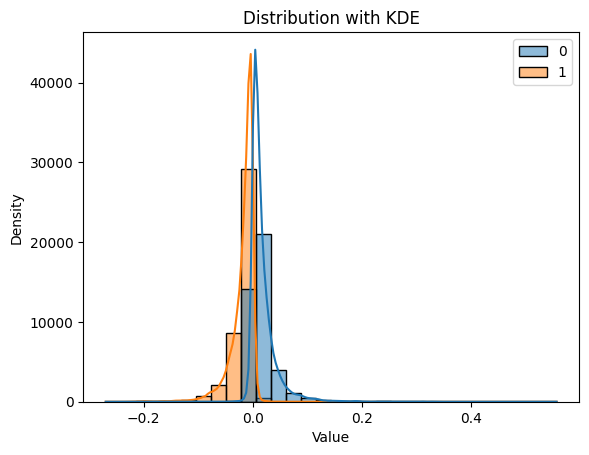

In [5]:
distribution(modelv1.unscaled_y_train)

In [8]:


modelv1.train()

I0000 00:00:1734325017.218471   28570 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-12-15 21:56:58.376431: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 372700000 exceeds 10% of free system memory.
2024-12-15 21:56:58.789697: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 372700000 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1734325021.800334   28977 service.cc:148] XLA service 0x72eff400ab00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734325021.800363   28977 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-15 21:57:01.906374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734325022.412635   28977 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/1165 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.3559 - mae: 0.4764 

I0000 00:00:1734325025.327172   28977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1165/1165 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - loss: 0.0527 - mae: 0.1556 - val_loss: 0.0121 - val_mae: 0.0861
Epoch 2/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0126 - mae: 0.0798 - val_loss: 0.0110 - val_mae: 0.0818
Epoch 3/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0106 - mae: 0.0702 - val_loss: 0.0097 - val_mae: 0.0741
Epoch 4/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 21.9479 - mae: 0.0923 - val_loss: 0.0090 - val_mae: 0.0680
Epoch 5/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0094 - mae: 0.0636 - val_loss: 0.0089 - val_mae: 0.0675
Epoch 6/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0090 - mae: 0.0617 - val_loss: 0.0086 - val_mae: 0.0659
Epoch 7/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.0089 - mae: 0.0609 - val_loss: 0.0087 - val_mae: 0.0669
Epoch 8/50
1165/1165 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0086 - mae: 0.0597 - val_loss: 0.0082 - val_mae: 0.0618
Epoch 9/50
1165/1165 ━━━━━━━━━━━━━

In [4]:
modelv1.load_Model('Scaled')

I0000 00:00:1735018336.286763   11177 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
total_profit, X_test, y_test, y_train, predictions = modelv1.return_profit()

2024-12-23 22:32:19.036227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103540000 exceeds 10% of free system memory.
I0000 00:00:1735018339.421893   11456 service.cc:148] XLA service 0x7ed27c006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735018339.421911   11456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-23 22:32:19.448703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735018339.560770   11456 cuda_dnn.cc:529] Loaded cuDNN version 90300


 25/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

I0000 00:00:1735018340.007764   11456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions:[[ 0.017639   -0.01618808]
 [ 0.01709265 -0.01639809]
 [ 0.03048979 -0.0284367 ]
 [ 0.02442027 -0.02138515]
 [ 0.047548   -0.03698634]
 [ 0.01369887 -0.0134461 ]
 [ 0.01835247 -0.01714688]
 [ 0.02041945 -0.02195122]
 [ 0.01888651 -0.01614244]
 [ 0.02414487 -0.02079504]]
Y-Tests:[[ 0.00485437 -0.00970874]
 [-0.00283286 -0.01983003]
 [ 0.01490826 -0.03555046]
 [ 0.02336449  0.00155763]
 [-0.01451613 -0.14354839]
 [ 0.00412882 -0.0015139 ]
 [ 0.06666667  0.00296296]
 [-0.00286944 -0.06025825]
 [ 0.0049505  -0.03041018]
 [ 0.00142349 -0.02918149]]
TP:[0, 0, np.float32(0.028965302), np.float32(0.023199258), np.float32(0.045170598), 0, 0, np.float32(0.019398475), 0, np.float32(0.022937626)]
SL:[0, 0, np.float32(-0.027014868), np.float32(-0.02031589), np.float32(-0.035137028), 0, 0, np.float32(-0.02085366), 0, np.float32(-0.019755285)]
Tot Profit: -57.683440510754934, Wins: 3430, Loses: 1640, No-trade: 5284


In [10]:
len(predictions)

10354

2024-12-23 22:32:30,170 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,176 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,181 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-23 22:32:30,184 - DEBUG - findfont: score(FontEntry(fname='/

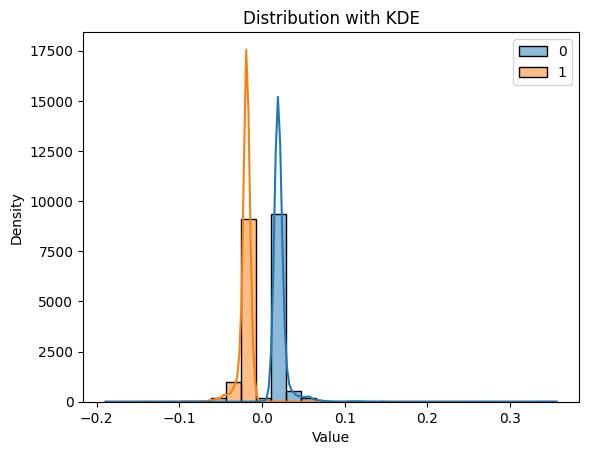

In [6]:
distribution(predictions)

In [33]:
# Make predictions
predictions = model.predict(X_test)

# Extract actual mix and max percentage changes
actual_max = [pair[0] for pair in y_test]
actual_min = [pair[1] for pair in y_test]

# Extract predicted max and min percentage changes
predicted_max = predictions[:, 0]
predicted_min = predictions[:, 1]

max_difference = actual_max - predicted_max


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


In [ ]:
import matplotlib.pyplot as plt # This sets the appropriate backend for Jupyter notebooks


import numpy as np

cut = 25
max_difference_cut = [max_difference[i]*100 for i in range(len(max_difference)) if i % cut == 0]

# max cuts
predicted_max_cut = [predicted_max[i]*100 for i in range(len(predicted_max)) if i % cut == 0]
actual_max_cut = [actual_max[i]*100 for i in range(len(actual_max)) if i % cut == 0]

# min cuts
predicted_min_cut = [predicted_min[i]*100 for i in range(len(predicted_min)) if i % cut == 0]
actual_min_cut = [actual_min[i]*100 for i in range(len(actual_min)) if i % cut == 0]

#df = pd.DataFrame(X_test)
#y_test = df.iloc[:, 2].to_numpy()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Size of the figure
#plt.plot(max_difference_25, label='Variation', color='green')  # Plot actual values
plt.plot(actual_max_cut, label='Actual', color='red')  # Plot actual values
plt.plot(predicted_max_cut, label='Predicted', color='blue')  # Plot predicted values

# Add labels and title
plt.xlabel('Index')  # You can also use time or other labels
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'max_difference' is not defined